#### BERT augmented CKY variant

Previously we looked at implementing the CKY algorithm to generate parse trees for sentences conforming to a context-free grammar in Chomsky-normal-form. We found that sentences generated by a CFG suffer from syntax ambiguities, i.e. a sentence can have multiple valid parse trees, each with a different meaning. However, we know that out of the different possible parses, typically only one of them is the "correct" one, i.e. captures the intended meaning of the sentence. 

In this notebook, we will look an a variant of the CKY algorithm in which each possible span of a sentence is assigned a score, and these scores can be used to arrive at the correct parse tree. These scores can be computed with the help of a neural network trained on an annotated treebank dataset. The training task simply involves predicting a distribution of scores over all possible non-terminal labels for each valid span/constituent of a sentence. After training this neural model, it is expected to assign large score to the correct label for each constituents of any given sentence, which will then help with the downstream task of disambiguating the correct parse tree (which will be done using a slightly modified CKY algorithm). A BERT model is powerful and well-suited for the score prediction task. The diagram below (borrowed from the Jurafsky-Martin textbook) summarizes the model architecture:

<img src="neural_parser.png" width="600" height="450">

We define the spans in the same way as we did for the vanilla CKY parser, i.e. using the "fencepost" positions. We also use the same upper-triangular matrix that which we used previously. Instead of using a pre-defined CFG in CNF to assign non-terminal labels to each element in this matrix (which represent the different possible spans), this time we will instead use BERT model to compute a distribution of scores over all possible terminals for each possible span. First, we create a fixed-size vector representation of the span and then feed it into an MLP classifier, as shown in the diagram. We outline the steps in more detail:

1) Convert words to subword tokens
2) Get `BERT embeddings for subwords`
3) Compute the `embeddings for full words` (many ways to do this, e.g. we could just assign the BERT em,bedding for the first subword of that word, or we could take the sum.average of the embedding of all the subwords or we could take element-wise max across all the subword embeddings, etc.)  
4) Compute `embeddings of fence posts` (shown as 0,1,2,3.. in the diagram above). Since each fence-post can represent the beginning or end of a span, we will create two separate representations. We first split the embedding vector $y_t$ of the $t$-th word in the sentence into two halves, $\overleftarrow{y_t}$ and $\overrightarrow{y_t}$ such that the concatentaion $[\overleftarrow{y_t}; \overrightarrow{y_t}] = y_t$. Then the `start-of-span representation` of the fencepost at position $i$ is defined as $\overrightarrow{y_i}$ and the `end-of-span representation` is defined as $\overleftarrow{y}_{i+1}$
5) Construct `embedding for a span` `(i,j)` using the fencepost embeddings as the following concatenation between the difference in start-of span and end-of-span embeddings for the bounding fenceposts: $v(i,j) = [\overrightarrow{y_j}-\overrightarrow{y_i}; \overleftarrow{y}_{j+1}-\overleftarrow{y}_{i+1}]$
6) Pass $v(i,j)$ through the MLP to get a distribution of scores over all possible non-terminal labels.

One really important thing to note here is that we are no longer using a pre-defined context-free grammar. The supervised training of the neural network model will implicitly induce/"learn" the grammar. Also, one downside is that the model may sometimes fail to get a grammatically correct parse of a sentence, because it does not have access to the "true grammar", only some form of statistical approximation of it.

After we implement and train this model, we will iplement the CKY variant that will perform the actual parsing using the scores computed by the BERT model.

In [1]:
from nltk.corpus import treebank
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import random
random.seed(10)
import psutil
print(torch.cuda.is_available())

True


Firstm let's load the data. We will use the NLTK treebank, which is a subset of the original Penn Treebank dataset.

In [2]:
# get all parsed sentences acrsoo all the files
sentences = treebank.sents()
parse_trees = treebank.parsed_sents()

# only keep sentences that are at most 100 words
sentences_parses = zip(sentences, parse_trees)
sentences_parses = [(s,p) for s,p in sentences_parses if len(s) <= 100]

sentences = [s for s,p in sentences_parses]
parse_trees = [p for s,p in sentences_parses]

print(f"Number of parsed sentences: {len(parse_trees)}")

Number of parsed sentences: 3910


1 92 25.58618925831202


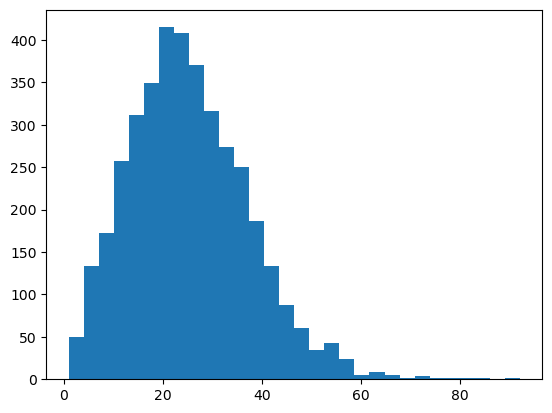

In [3]:
sentences_lengths = [len(s) for s in sentences]
print(min(sentences_lengths), max(sentences_lengths), sum(sentences_lengths)/len(sentences_lengths))

# plot a histogram of sentence lengths
import matplotlib.pyplot as plt
plt.hist(sentences_lengths, bins=30)
plt.show()

In [4]:
# print example of a parsed sentence
example_tree = parse_trees[0]
print(example_tree)

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


In [5]:
# funciton for extracting all the non-terminal labels for all possible spans from each sentence
def get_span_labels(parse_tree, verbose=False):
    span_labels = {}
    if verbose:
        parse_tree.pretty_print()
    # iterate over all subtrees in level-order traversal
    for subtree in parse_tree.subtrees():       
        span = (parse_tree.leaves().index(subtree.leaves()[0]), parse_tree.leaves().index(subtree.leaves()[-1])+1)
        span_labels[span] = subtree.label()
        if verbose:
            print(f"\nsubtree label: {subtree.label()}")
            print(f"subtree leaves: {subtree.leaves()}")
            print(f"Start fence-post: {parse_tree.leaves().index(subtree.leaves()[0])}")
            print(f"End fence-post: {parse_tree.leaves().index(subtree.leaves()[-1])+1}")
            print(f"span: {span}")
    return span_labels            

In [6]:
get_span_labels(example_tree, verbose=True)

                                                     S                                                                         
                         ____________________________|_______________________________________________________________________   
                        |                                               VP                                                   | 
                        |                        _______________________|___                                                 |  
                      NP-SBJ                    |                           VP                                               | 
         _______________|___________________    |     ______________________|______________________________________          |  
        |          |              ADJP      |   |    |        |                PP-CLR                              |         | 
        |          |           ____|____    |   |    |        |          ________|_________          

{(0, 18): 'S',
 (0, 3): 'NP-SBJ',
 (0, 2): 'NP',
 (0, 1): 'NNP',
 (1, 2): 'NNP',
 (2, 3): ',',
 (3, 6): 'ADJP',
 (3, 5): 'NP',
 (3, 4): 'CD',
 (4, 5): 'NNS',
 (5, 6): 'JJ',
 (7, 17): 'VP',
 (7, 8): 'MD',
 (8, 17): 'VP',
 (8, 9): 'VB',
 (9, 11): 'NP',
 (9, 10): 'DT',
 (10, 11): 'NN',
 (11, 15): 'PP-CLR',
 (11, 12): 'IN',
 (12, 15): 'NP',
 (12, 13): 'DT',
 (13, 14): 'JJ',
 (14, 15): 'NN',
 (15, 17): 'NP-TMP',
 (15, 16): 'NNP',
 (16, 17): 'CD',
 (17, 18): '.'}

Now lets create a pytorch dataset for creating the (input, target) instances for our BERT span score prediction model.

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [8]:
sentence = sentences[0]
input_encoding = tokenizer.encode_plus(sentence, is_split_into_words=True, return_offsets_mapping=False, padding=False, truncation=False, add_special_tokens=True)
input_idx = input_encoding['input_ids']
word_ids = input_encoding.word_ids()
print(sentences[0])
print(input_idx)
print(tokenizer.convert_ids_to_tokens(input_idx))
print(word_ids)

# get all possible word spans for the sentence
word_spans = [(i, j+1) for i in range(len(sentence)) for j in range(i, len(sentence))]
print(word_spans)

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
[101, 5578, 19354, 7520, 1010, 6079, 2086, 2214, 1010, 2097, 3693, 1996, 2604, 2004, 1037, 3904, 2595, 8586, 28546, 2472, 13292, 1012, 2756, 1012, 102]
['[CLS]', 'pierre', 'vin', '##ken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'none', '##x', '##ec', '##utive', 'director', 'nov', '.', '29', '.', '[SEP]']
[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, None]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 

In [9]:
# get span labels for all sentences
span_labels = [get_span_labels(p) for p in parse_trees]

# create mapping of span labels to unique ids
unique_span_labels = list(set([label for span in span_labels for label in span.values()]))
label2idx = {label: i for i, label in enumerate(unique_span_labels)}    

# create train-val splits
n_train = int(0.9 * len(sentences))
sentences_train = sentences[:n_train]
parse_trees_train = parse_trees[:n_train]
span_labels_train = span_labels[:n_train]
sentences_val = sentences[n_train:]
parse_trees_val = parse_trees[n_train:]
span_labels_val = span_labels[n_train:]

In [10]:
class ParseTreeDataset(Dataset):
    def __init__(self, sentences, span_labels, label2idx, block_size=256, max_spans=64):
        self.sentences = sentences
        self.parse_trees = parse_trees
        self.span_labels = span_labels
        self.label2idx = label2idx
        self.block_size = block_size
        self.max_spans = max_spans
        self.tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    def get_span_labels(self, parse_tree):
        span_labels = {}
        # iterate over all subtrees in level-order traversal
        for subtree in parse_tree.subtrees():       
            span = (parse_tree.leaves().index(subtree.leaves()[0]), parse_tree.leaves().index(subtree.leaves()[-1])+1)
            span_labels[span] = subtree.label()
        return span_labels 

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        # get sentence and span labels
        sentence = self.sentences[idx]
        span_labels = self.span_labels[idx]
        # convert span labels to indices
        span_labels_idx = {span:self.label2idx[label] for span, label in span_labels.items()}

        # tokenize the sentence
        input_encoding = self.tokenizer.encode_plus(sentence, is_split_into_words=True, return_offsets_mapping=False, padding=False, truncation=False, add_special_tokens=True)
        input_idx = input_encoding['input_ids']
        word_ids = input_encoding.word_ids()

        if len(input_idx) > self.block_size:
            raise ValueError(f"Tokenized sentence {idx} is too long: {len(input_idx)}. Truncation unsupported.")

        # add padding 
        input_idx = input_idx + [self.tokenizer.pad_token_id] * (self.block_size - len(input_idx))    
        # create attention mask 
        input_attn_mask = [1 if idx != self.tokenizer.pad_token_id else 0 for idx in input_idx]

        # convert to tensors
        input_idx = torch.tensor(input_idx)
        input_attn_mask = torch.tensor(input_attn_mask) 
        
        return input_idx, input_attn_mask, word_ids, span_labels_idx   


def collate_fn(batch):
    # Separate the tensors and the dictionaries
    input_idxs, input_attn_masks, word_ids, span_labels_idx = zip(*batch)

    # Default collate the tensors
    input_idxs = torch.stack(input_idxs)
    input_attn_masks = torch.stack(input_attn_masks)

    # Pad word_ids to the longest sequence in the batch
    #max_length = max(len(ids) for ids in word_ids)
    #padded_word_ids = [ids + [None] * (max_length - len(ids)) for ids in word_ids]

    # Handle the dictionaries
    spans_labels = []
    for d in span_labels_idx:
        # Convert the dictionary to two lists: one for spans and one for labels
        spans, labels = zip(*d.items())
        spans_labels.append((spans, labels))

    return input_idxs, input_attn_masks, word_ids, spans_labels


Now lets implement the BERT model for span score prediction.

In [11]:
class BERT_CKY_scorer(torch.nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1, mlp_hidden_size=128):
        super().__init__()
        # load pretrained BERT model
        self.bert_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = torch.nn.Dropout(dropout_rate)
        # define classifier head (2 layer MLP)
        self.classifier_head = torch.nn.Sequential(
            torch.nn.Linear(self.bert_encoder.config.hidden_size, mlp_hidden_size),
            torch.nn.LayerNorm(mlp_hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(mlp_hidden_size, num_classes)
        )
        
        # make sure BERT parameters are trainable
        for param in self.bert_encoder.parameters():
            param.requires_grad = True

    def forward(self, input_idx, input_attn_mask, batch_word_ids, targets=None):
        # compute BERT embeddings for input tokens
        bert_output = self.bert_encoder(input_idx, attention_mask=input_attn_mask)
        bert_output = self.dropout(bert_output.last_hidden_state) # shape: (batch_size, block_size, hidden_size)

        if targets is not None:
            # for each sequence, get word embeddings for each word by using the BERT embeddings for first subword token for that word
            logits = []
            loss = 0.0
            for i, word_ids in enumerate(batch_word_ids):
                word_embeddings = [bert_output[i,0,:]] # add CLS token embedding
                # construct embeddings for each word in the original (untokenized) sequence
                for j in range(word_ids[-2]+1):
                    y_j = bert_output[i,word_ids.index(j),:] # gets first subword token embedding for word j
                    word_embeddings.append(y_j)        
                word_embeddings.append(bert_output[i,len(word_ids)-1,:]) # add SEP token embedding

                # now that we have the word embeddings, we need to construct the span embeddings
                spans, labels = targets[i]
                span_logits = []
                for i,j in spans:
                    # get right and left fencepost embeddings for the bounding fenceposts of this span
                    y_j_right = word_embeddings[j][768//2:]
                    y_i_right = word_embeddings[i][768//2:]
                    y_jplus1_left = word_embeddings[j+1][:768//2]
                    y_iplus1_left = word_embeddings[i+1][:768//2]
                    # concatenate difference vectors to get span embedding
                    span_embedding = torch.cat([y_j_right-y_i_right, y_jplus1_left-y_iplus1_left], dim=0) # shape: (hidden_size,)
                    # compute logits for this span
                    span_logits.append(self.classifier_head(span_embedding)) # shape: (num_classes,)

                span_logits = torch.stack(span_logits, dim=0) # shape: (num_spans, num_classes)
                logits.append(span_logits)
                # accumulate loss for the spans in this sequence (note that we only compute losses for labeled spans)
                loss += F.cross_entropy(span_logits, torch.tensor(labels, device=input_idx.device))

            loss = loss / len(input_idx) # average loss over batch
            return logits, loss

        else:
            loss = None
            logits = []
            batch_spans = []
            for i, word_ids in enumerate(batch_word_ids):
                word_embeddings = [bert_output[i,0,:]] # add CLS token embedding
                # construct embeddings for each word in the original (untokenized) sequence
                for j in range(word_ids[-2]+1):
                    y_j = bert_output[i,word_ids.index(j),:] # gets first subword token embedding for word j
                    word_embeddings.append(y_j)        
                word_embeddings.append(bert_output[i,len(word_ids)-1,:]) # add SEP token embedding

                # in inference mode, we will compute scores for all possible spans
                spans = [(i, j+1) for i in range(len(word_embeddings)) for j in range(i, len(word_embeddings))]
                # compute logits
                span_logits = []
                for i,j in spans:
                    # get right and left fencepost embeddings for the bounding fenceposts of this span
                    y_j_right = word_embeddings[j][768//2:]
                    y_i_right = word_embeddings[i][768//2:]
                    y_jplus1_left = word_embeddings[j+1][:768//2]
                    y_iplus1_left = word_embeddings[i+1][:768//2]
                    span_embedding = torch.cat([y_j_right-y_i_right, y_jplus1_left-y_iplus1_left], dim=0) # shape: (hidden_size,)                    
                    # compute logits for each span
                    span_logits.append(self.classifier_head(span_embedding)) # shape: (num_classes,)  
                span_logits = torch.stack(span_logits, dim=0) # shape: (num_spans, num_classes)
                logits.append(span_logits)
                batch_spans.append(spans)
            return logits, batch_spans
        


# training loop
def train(model, optimizer, train_dataloader, val_dataloader, scheduler=None, device="cpu", num_epochs=10, val_every=100, save_every=None, log_metrics=None):
    avg_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    model.train()
    # reset gradients
    optimizer.zero_grad()
    for epoch in range(num_epochs):
        num_correct = 0
        num_total = 0
        pbar = tqdm(train_dataloader, desc="Epochs")
        for i, batch in enumerate(pbar):
            input_idx, input_attn_mask, word_ids, targets = batch
            # move batch to device
            input_idx, input_attn_mask = input_idx.to(device), input_attn_mask.to(device)
            # forward pass
            logits, loss = model(input_idx, input_attn_mask, word_ids, targets)
            # reset gradients
            optimizer.zero_grad()
            # backward pass
            loss.backward()
            # optimizer step
            optimizer.step()

            if scheduler is not None:
                    scheduler.step()

            avg_loss = 0.9* avg_loss + 0.1*loss.item()
            B, _ = input_idx.shape
            # concatenate the labels and logits over the batch
            logits = torch.cat(logits, dim=0)
            labels = torch.tensor([label for spans,labels in targets for label in labels], device=input_idx.device)
            y_pred = logits.argmax(dim=-1).view(-1) 
            # compute accuracy
            num_correct += y_pred.eq(labels).sum().item()
            num_total += len(labels)
            train_acc = num_correct / num_total        

            if val_every is not None:
                if i%val_every == 0:
                    # compute validation loss
                    val_loss, val_acc = validation(model, val_dataloader, device=device)
                    pbar.set_description(f"Epoch {epoch + 1}, EMA Train Loss: {avg_loss:.3f}, Train Accuracy: {train_acc: .3f}, Val Loss: {val_loss: .3f}, Val Accuracy: {val_acc: .3f}")  

            pbar.set_description(f"Epoch {epoch + 1}, EMA Train Loss: {avg_loss:.3f}, Train Accuracy: {train_acc: .3f}, Val Loss: {val_loss: .3f}, Val Accuracy: {val_acc: .3f}")  

            if log_metrics:
                metrics = {"Batch loss":loss.item(), "Moving Avg Loss":avg_loss, "Train Accuracy":train_acc, "Val Loss": val_loss, "Val Accuracy":val_acc}
                log_metrics(metrics)

        if save_every is not None:
            if (epoch+1) % save_every == 0:
                save_model_checkpoint(model, optimizer, epoch, avg_loss)


def validation(model, val_dataloader, device="cpu"):
    model.eval()
    val_losses = torch.zeros(len(val_dataloader))
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for i,batch in enumerate(val_dataloader):
            input_idx, input_attn_mask, word_ids, targets = batch
            input_idx, input_attn_mask = input_idx.to(device), input_attn_mask.to(device)
            logits, loss = model(input_idx, input_attn_mask, word_ids, targets)
            B, _ = input_idx.shape
            # concatenate the labels and logits over the batch
            logits = torch.cat(logits, dim=0)
            labels = torch.tensor([label for spans,labels in targets for label in labels], device=input_idx.device)
            y_pred = logits.argmax(dim=-1).view(-1) 
            # compute accuracy
            num_correct += y_pred.eq(labels).sum().item()
            num_total += len(labels)
            val_losses[i] = loss.item()
    model.train()
    val_loss = val_losses.mean().item()
    val_accuracy = num_correct / num_total
    return val_loss, val_accuracy


def save_model_checkpoint(model, optimizer, epoch=None, loss=None, filename='BERT_CKY_checkpoint.pth'):
    # Save the model and optimizer state_dict
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    # Save the checkpoint to a file
    torch.save(checkpoint, filename)
    print(f"Saved model checkpoint!")


def load_model_checkpoint(model, optimizer=None,  filename='BERT_CKY_checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded model from checkpoint!")
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.train()
        return model, optimizer          
    else:
        return model        

In [12]:
B = 16
DEVICE = "cuda"
learning_rate = 1e-5
epochs = 3

train_dataset = ParseTreeDataset(sentences_train, span_labels_train, label2idx)
val_dataset = ParseTreeDataset(sentences_val, span_labels_val, label2idx)

train_dataloader = DataLoader(train_dataset, batch_size=B, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=B, collate_fn=collate_fn)

In [13]:
# model with finetuning disabled
model = BERT_CKY_scorer(num_classes=len(label2idx)).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs 
warmup_steps = int(len(train_dataloader) * 0.1 *  epochs) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
#model, optimizer = load_model_checkpoint(model, optimizer)

num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in transformer network: {num_params/1e6} M")
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

Total number of parameters in transformer network: 66.513942 M
RAM used: 2610.34 MB


In [14]:
train(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, num_epochs=epochs, scheduler=scheduler, save_every=None, val_every=30) 

Epoch 1, EMA Train Loss: 5.850, Train Accuracy:  0.005, Val Loss:  6.002, Val Accuracy:  0.002:  27%|██▋       | 60/220 [00:39<01:26,  1.84it/s]